# Tutorial 20a: Coherent Spatio-Temporal Scale-separation (CoSTS) with toy data

In this tutorial we build a toy data set:
- An oscillator with nearly overlapping frequencies between two dynamic systems
- An added transient feature.
- All influenced by a white noise process.

The CoSTS algorithm can be used to separate out each of these individual components, albeit with some hyperparameter tuning. Bad sets of hyperparameters are often indicated by poorly reconstructed windows. However, a sufficiently high level of noise or too large of an initial window can mask the transient feature, which drops out for the next decomposition levels.

**Note**: This tutorial walks more explicitly details the mrCOSTS methods by interacting with the lower level functions inside of the COSTS module. This is an approximation of the algorithm inside mrCOSTS. The tutorial is intended to gain intuition of the higher-level mrCOSTS module. The very end of the tutorial shows how to fit using the mrCOSTS module.

## Imports

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import copy
import scipy
from scipy.integrate import solve_ivp
from pydmd.costs import COSTS
from pydmd.mrcosts import mrCOSTS

# import plotting
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set up toy data

## Solve the Overlapping-Scale Oscillators Example

- FitzHugh-Nagumo Model
- Unforced Duffing Oscillator


From Dylewsky et al., (2019):

"The FitzHugh-Nagumo model, used as a simple model for biological neuron dynamics, spikes sharply at intervals determined by its characteristic time scale. The Duffing model, on the other hand, is a simple nonlinear oscillator whose dynamics resemble a distorted sinusoid. Therefore, despite the disparity between τ1 and τ2, the “slow” component periodically acquires a rate of change comparable to that of the “fast” component."

In [3]:
def rhs_FNM(t, x, tau, a, b, Iext):
    """FitzHugh-Nagumo Model

    See costs-tutorial_toy-data for details.
    """
    v = x[0]
    w = x[1]
    vdot = v - (v**3) / 3 - w + Iext
    wdot = (1 / tau) * (v + a - b * w)
    dx = np.array([vdot, wdot])

    return dx


def rhs_UFD(t, y, eta, epsilon, tau):
    """Unforced Duffing Oscillator

    See costs-tutorial_toy-data for details.
    """
    p = y[0]
    q = y[1]
    pdot = q
    qdot = (1 / tau) * (-2 * eta * q - p - epsilon * p**3)
    dy = np.array([pdot, qdot])

    return dy


T = 64

x0 = np.array([-1.110, -0.125])
tau1 = 2
a = 0.7
b = 0.8
Iext = 0.65

y0 = np.array([0, 1])
eta = 0
epsilon = 1
tau2 = 0.2

# RK4 integration of the mixed system
dt = 0.0001 * 8
t_solution = np.arange(0, T, dt)

# Solve the FitzHugh-Nagumo Model
solution_fn = solve_ivp(rhs_FNM, [0, T], x0, t_eval=t_solution, args=(tau1, a, b, Iext))

# Solve the Unforced Duffing Oscillator Model
solution_ufd = solve_ivp(
    rhs_UFD, [0, T], y0, t_eval=t_solution, args=(eta, epsilon, tau2)
)

# We now turn this into a complex spatiotemporal dataset by
# stacking multiple "spatial dimensions" where each spatial dimension
# is an orthonormal mixture of the input data.
seed = 1
num_space_dims = 10

uv_tiled = np.hstack(
    [
        np.tile(solution_fn.y.T, num_space_dims),
        np.tile(solution_ufd.y.T, num_space_dims),
    ]
)

# Subsample after solving the pdes
substep = 50
uv_tiled = uv_tiled[0::substep, :]
t_solution = t_solution[0::substep]
time = t_solution

# Dimension of space to map into
n_space_dims = np.shape(uv_tiled)[1]
n_time = np.shape(uv_tiled)[0]

# Orthonormalized linear mixing matrix
Q = scipy.stats.ortho_group.rvs(n_space_dims, random_state=seed)
Q = Q[0:n_space_dims, :]
x = uv_tiled @ Q

# COSTS expects time by space, so we transpose x.
data_original = x.T

# For the scale separation we want to compare to the actual slow and fast
# components.
slow_modes = uv_tiled[:, 0 : n_space_dims // 2] @ Q[0 : n_space_dims // 2, :]
fast_modes = uv_tiled[:, n_space_dims // 2 :] @ Q[n_space_dims // 2 :, :]

## Add a transient feature

In [4]:
space_dim = np.arange(n_space_dims)
xgrid, tgrid = np.meshgrid(space_dim, time)

# Add a transient wave packet
recon_filter_sd = len(t_solution) * 0.25

recon_filter = np.exp(
    -((np.arange(n_time) - (n_time + 1) / 2) ** 2) / recon_filter_sd**2
)
recon_filter[recon_filter < 0.0001] = 0
f_transient = 10
x_transient = 2 * np.sin(f_transient * tgrid + xgrid / (2 * np.pi))
x_transient = x_transient.T * recon_filter

# Add the transient feature to the data
data_transient = data_original + np.atleast_2d(x_transient)

## Add white noise

In [5]:
# Adding noise absolutely wrecks the mrd fit.
rng = np.random.default_rng(seed)
data_noisy = data_transient + rng.normal(0, 0.2, size=(n_space_dims, n_time))

## Visualize the completed dataset

Conditon number of toy data (smaller is better): 23.34


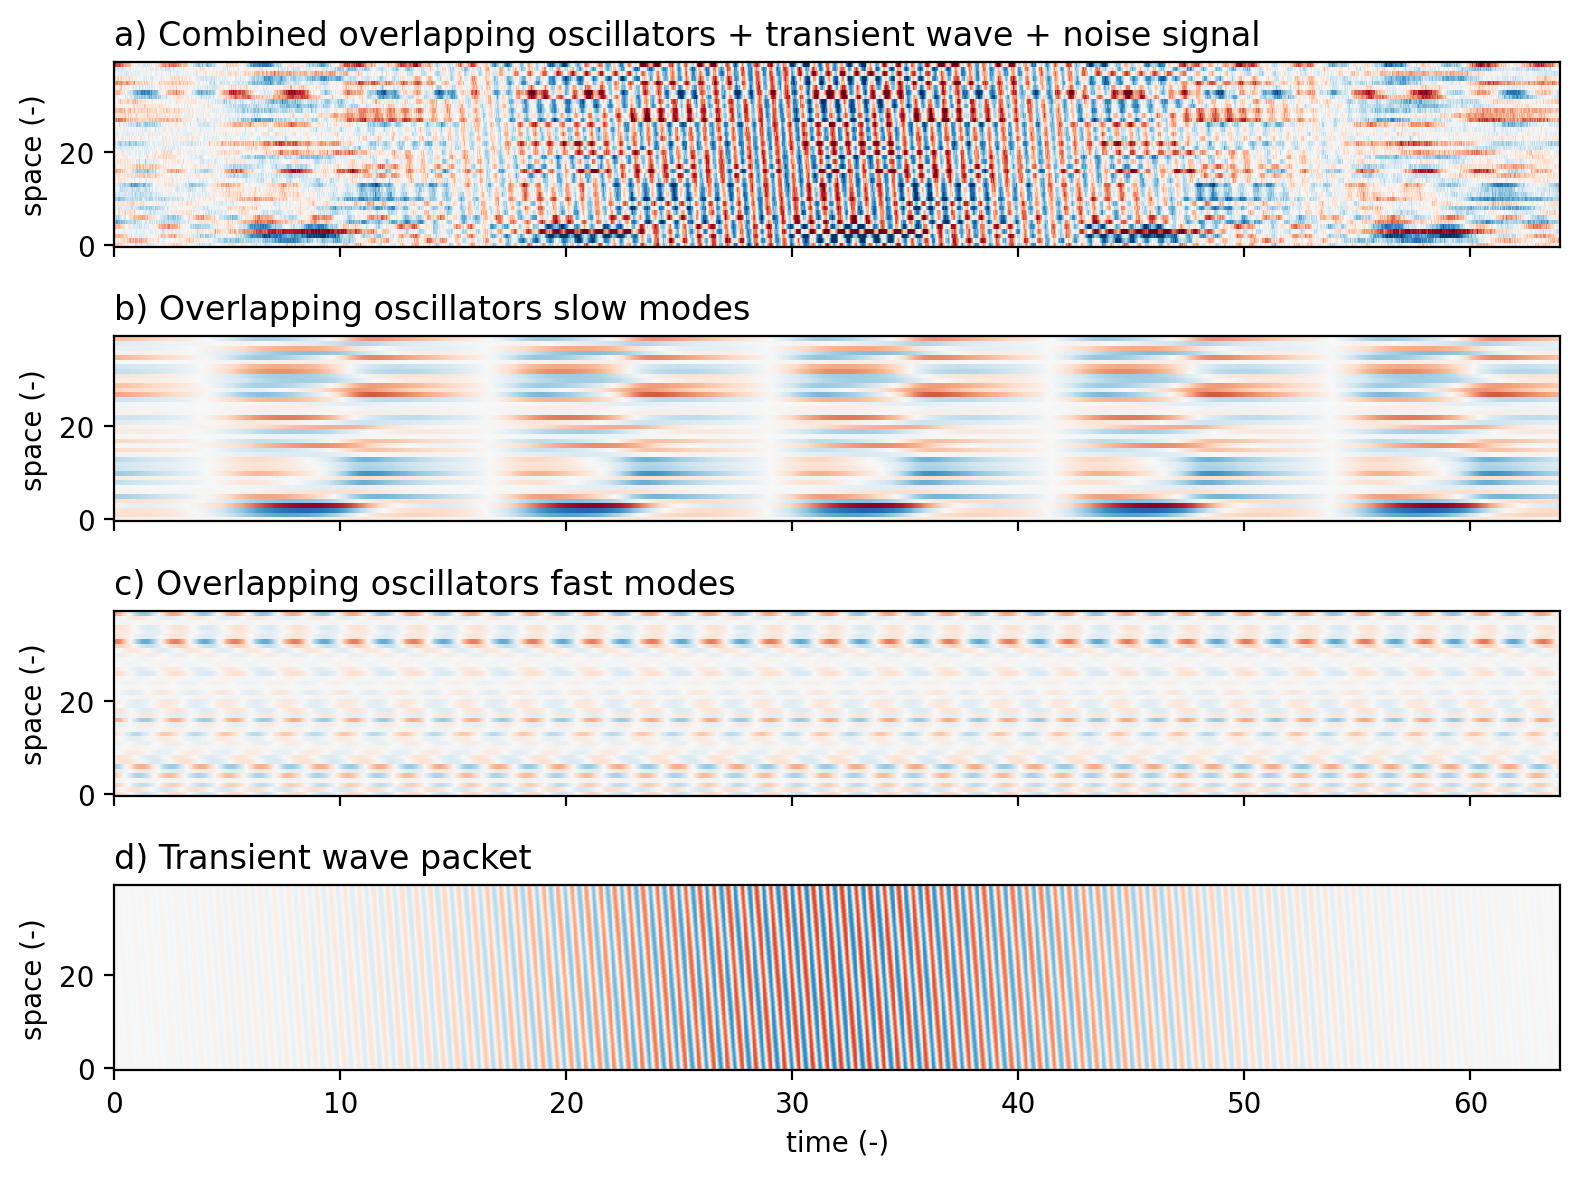

In [6]:
pcolor_kwargs = {
    "vmin": -3,
    "vmax": 3,
    "cmap": "RdBu_r",
}

fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True, sharey=True)
ax = axes[0]

# Original data
ax = axes[0]
ax.pcolor(time, space_dim, data_noisy, **pcolor_kwargs)
ax.set_title(
    "a) Combined overlapping oscillators + transient wave + noise signal", loc="left"
)
ax.set_ylabel("space (-)")

ax = axes[1]
ax.pcolor(time, space_dim, slow_modes.T, **pcolor_kwargs)
ax.set_title("b) Overlapping oscillators slow modes", loc="left")
ax.set_ylabel("space (-)")

ax = axes[2]
ax.pcolor(time, space_dim, fast_modes.T, **pcolor_kwargs)
ax.set_title("c) Overlapping oscillators fast modes", loc="left")
ax.set_ylabel("space (-)")

ax = axes[3]
ax.pcolor(time, space_dim, x_transient, **pcolor_kwargs)
ax.set_title("d) Transient wave packet", loc="left")
ax.set_xlabel("time (-)")
ax.set_ylabel("space (-)")

fig.tight_layout()

print(
    "Conditon number of toy data (smaller is better): {:.2f}".format(
        np.linalg.cond(data_noisy)
    )
)

# mrCOSTS

## Settings

### Choosing window sizes

How big should the window be? This question can be non-trivial to answer, especially for toy data. Following the advice in Dylewsky et al., (2019) we should have a window size somewhere around 2 * the period of the fastest feature. 

When the window is too large and/or the svd rank is too small to fit the data well, the highest frequency features are simply dropped. This behavior can be accidentally nice when wanting to ignore high frequency components but frustrating in the cases when these components need to be retained. When this behavior is noted it is recommened to add a level with a shorter window length. Increasing the `svd_rank` keyword can help but a window that is too long will hinder the fitting of the model.

For more brittle data, i.e. this toy data set with its very large condition number, the window size is the most sensitive hyperparameter to tune. Changing the window size to be smaller allows for fitting finer scale features while larger windows tend to focus on larger scale features. 

Fortunately, for real data with more continuously distributed frequency bands the window size selection is less impactful. Real data with many features present tend to be more forgiving.

## Keywords:

- `window_length_array`: One of the fundamental properties of decompositions is the window length of the data that is decomposed. Unlike most other decompositions we must manually set these window sizes. In this case dyadic scaling works just fine so we specify the `window_length_array` keyword as the window lengths (in units of time steps) for each decomposition level. **Critical to note**: mrCOSTS operates in the opposite direction of most decompositions, starting from the smallest scales and moving the largest scales.
- `step_size_array`: For each decomposition we slide the window across the data in the time dimension. While we can do this for each time step, this is often unnecessarily computationally expensive. Instead, we "step" the window by a fixed number of time steps. The `step_size_array` specifies how to slide each window across the data. Here we chose a fixed slide of about 7%. Dylewsky et al., (2019) suggested 4%. Generally the slide width should be a small fraction of the window width.
- `svd_rank_array`: Specifies the svd_rank to use when fitting the BOP-DMD for each window. The `svd_rank` controls the number of frequency bands. Odd numbers force one of the fitted eigenvalues to have a large positive component. Even ranks tend towards fits with conjugate pairs. **Note**: one can force conjugate pair solutions using the BOP-DMD `eig_constraints` keyword argument.
- `global_svd_array`: Specifies if each level should use a global svd for the projection basis and initial eigenvalues using the entire dataset instead of individually for each window BOP-DMD fits (`True`) or not (`False`). Setting this value to True forces all of the BOP-DMD solutions towards eigenvalues representative for the entire data set and not just the specific window being fit. Generally using the global_svd speeds up the fitting process with the trade-off of not fitting dynamics which are not present throughout the entire dataset.
- `cluster_sweep`: Specifies if mrCOSTS should performa hyperparameter sweep when clustering the fitted eigenvalues from each window. When `True` it looks for the optimal number of eigenvalue clusters using the Silhouette score. If `False `the `n_components_array` keyword must be provided, specifying the number of frequency bands to use when clustering the fitted eigenvalues.
- `transform_method` dictates how the eigenvalue frequencies (the imaginary components) are transformed for the scale-separation step. See the below histograms for an illustration. Generally, for real data we find that `transform_method="absolute_value"` is the more reliable option.
- `eig_constraints` can be provided (see `bopdmd` module) using `pydmd_kwargs`. In testing, strict eigenvalue constraints do not perform well. We always recommend using the `conjugate_pairs` eigenvalue constraint as the definition of a DMD model becomes ambiguous otherwise.

## Drive the recursive decomposition

In [7]:
window_lengths = [30, 120, 360, 720]
step_sizes = [3, 10, 10, 10]
n_components_array = [2, 2, 2, 2]
transform_method = "absolute"
svd_ranks = [4, 4, 4, 4]
pydmd_kwargs = {"eig_constraints": {"conjugate_pairs"}}
global_svd_array = [False] * len(window_lengths)

mrc = mrCOSTS(
    svd_rank_array=svd_ranks,
    window_length_array=window_lengths,
    step_size_array=step_sizes,
    global_svd_array=global_svd_array,
    transform_method=transform_method,
    n_components_array=n_components_array,
    kern_method="flat",
    pydmd_kwargs=pydmd_kwargs,
)
mrc.fit(data_noisy, np.atleast_2d(time))

_________________________________________________
Fitting window length = 30
0 of 525
50 of 525
100 of 525
150 of 525
200 of 525
250 of 525
300 of 525
350 of 525
400 of 525
450 of 525
500 of 525
Error in Global Reconstruction = 0.16
_________________________________________________
Fitting window length = 120
0 of 149
50 of 149
100 of 149
Error in Global Reconstruction = 0.061
_________________________________________________
Fitting window length = 360
0 of 125
50 of 125
100 of 125
Error in Global Reconstruction = 0.051
_________________________________________________
Fitting window length = 720
0 of 89
50 of 89
Error in Global Reconstruction = 0.033


## Visualize the results

Set `plot_flag` to `True` to see a little under the hood of the mrCOSTS fitting. Here you can see what the local decomposition looks like.

In [8]:
plot_flag = False

if plot_flag:
    for nmrd, mrd in enumerate(mrc.costs_array):
        # Omega histograms and time series.
        window = mrd.window_length
        fig1, ax1 = mrd.plot_omega_histogram()
        fig1.suptitle("Window length={} time steps".format(window))

        fig2, ax2 = mrd.plot_omega_time_series()
        fig2.suptitle("Window length={} time steps".format(window))

        # Scale separation
        xr_sep = mrd.scale_reconstruction()

        fig, axes = plt.subplots(len(np.unique(mrd.omega_classes)) + 1, 1, sharex=True)

        if nmrd == 0:
            x_iter = data_noisy
        else:
            x_iter, _ = mrc.costs_array[nmrd - 1].scale_separation(
                scale_reconstruction_kwargs=mrc._costs_recon_kwargs
            )

        ax = axes[0]
        ax.plot(time.squeeze(), x_iter.T, color="k")
        ax.set_ylabel("Amplitude (-)")
        ax.set_xlabel("Time (-)")
        ax.set_title("Input Data")
        ax.autoscale(enable=True, axis="both", tight=True)

        # Change the underlying data depending on which feature is being separated.
        if nmrd == 0:
            axes[1].plot(time.squeeze(), x, color="k")
            axes[1].set_title("Reconstruction overlapping oscillators")
            axes[2].plot(time.squeeze(), x_transient.T, color="k")
            axes[2].set_title("Reconstruction transient wave packet")

        elif nmrd == 1:
            axes[1].plot(time.squeeze(), slow_modes, color="k")
            axes[1].set_title("Reconstruction slow modes")
            axes[2].plot(time.squeeze(), fast_modes, color="k")
            axes[2].set_title("Reconstruction fast modes")

        elif nmrd == 2:
            axes[1].plot(time.squeeze(), slow_modes, color="k")
            axes[1].set_title("Background modes")
            axes[2].set_title("Poorly resolved slow modes")

        elif nmrd == 3:
            axes[1].set_title("Background modes")
            axes[2].set_title("Better resolved slow modes")
            axes[2].plot(time.squeeze(), slow_modes, color="k")

        for no, o in enumerate(np.unique(mrd.omega_classes)):
            ax = axes[no + 1]
            ax.plot(time.squeeze(), xr_sep[no, :, :].T, "r")
            ax.set_ylabel("Amplitude (-)")
            ax.set_xlabel("Time (-)")
            ax.autoscale(enable=True, axis="both", tight=True)

        fig.tight_layout()

## Global clustering

Here we have some somewhat complicated decompositions to look at. The "slow modes" are made up of several frequency bands which were split across two decomposition levels. Additionally, the slowly varying background mode (found in the last figure if you run the plots above) adds a constant magnitude offset to the slow modes. These two factors combined, the slow modes being made up of a constant background value plus the multiple constituent frequencies, makes the comparison at the local level look poor.

The global clustering (Step 3 in the PNAS article's Figure 1) allows us to merge frequency bands between decomposition levels. Here we use our knowledge of the system, that the slow modes are made up of a slow oscillation that occassionally approaches the frequency of the fast oscillator, to inform our decision that we have 3 frequency bands instead of 4.

To be clear, using 4 components would be justified. But, since we want to compare back to the original system we choose to use 3 frequency bands so we can do an apples-to-apples comaprison.

In [9]:
# If you want to do an objective parameter sweep set the `cluster_sweep` flag to `True`.

cluster_sweep = False
if cluster_sweep:
    n_components_range = np.arange(2, 7)
    scores, n_optimal = mrc.global_cluster_hyperparameter_sweep(
        n_components_range,
        transform_method="log10",
    )
    print("Optimal silhouette score is = {}".format(n_optimal))
else:
    # We know the system has three components.
    n_optimal = 3

cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
    n_optimal, transform_method="log10"
)

Visualize the global clustering.

Text(0.5, 0, 'Frequency (Hz)')

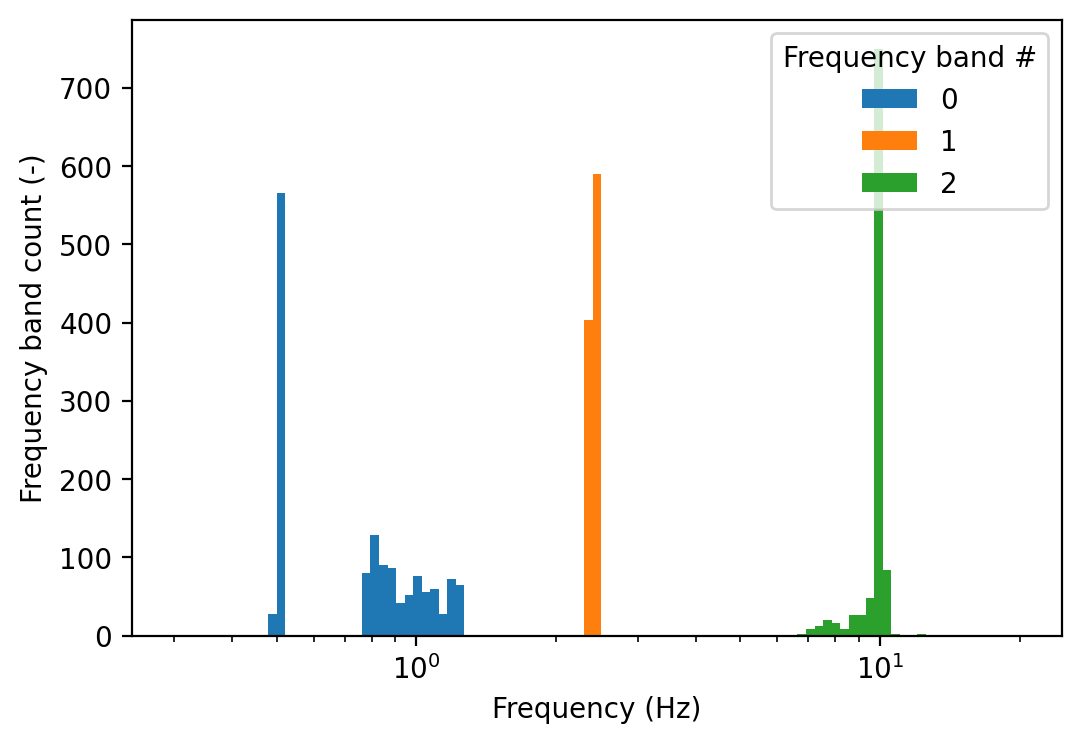

In [10]:
omega_plot = np.zeros((len(omega_array), n_optimal)) * np.nan
for n in range(n_optimal):
    ind = omega_classes == n
    omega_plot[ind, n] = omega_array[ind]

plt.figure(figsize=(6, 4))
plt.hist(
    x=10**omega_plot,
    bins=np.logspace(start=np.log10(0.3), stop=np.log10(20), num=100),
    histtype="barstacked",
    label=range(n_optimal),
)
plt.legend(title="Frequency band #")
plt.xscale("log")
plt.ylabel("Frequency band count (-)")
plt.xlabel("Frequency (Hz)")

You could justify that the frequency band with a central frequency of ~ 1 Hz could belong as its own band. However, here we know how the data were constructed and use that information. It is a common and accepted practice to aggregate mrCOSTS bands to retrieve physically meaningful reconstructions.



## Notes

- The white noise dropped out in the first level, which is a desirable side effect.
- You can play with the transient feature or adjust the fit rank and decomposition lengths to explore the trade off of too large a rank or too small of a window.
- Previous versions had enhanced error near the edges of the time domain. This error has been reduced through improvements to the mrCOSTS algorithm but are not totally removed. It is good to be extra cautious of the fits at the edges of the time domain.

# Reconstruction and fit evaluation

In [11]:
xr_sep_global = mrc.global_scale_reconstruction()
xr_background = mrc.get_background()
xr_global = mrc.global_reconstruction()

band_slow = 0
band_fast = 1
band_transient = 2

xr_fast = xr_sep_global[:, band_fast, :].sum(axis=(0)).real
xr_slow = xr_sep_global[:, band_slow, :].sum(axis=(0)).real
xr_transient = xr_sep_global[:, band_transient, :].sum(axis=(0)).real

space_dim = np.arange(0, n_space_dims)

## Visualize the fit

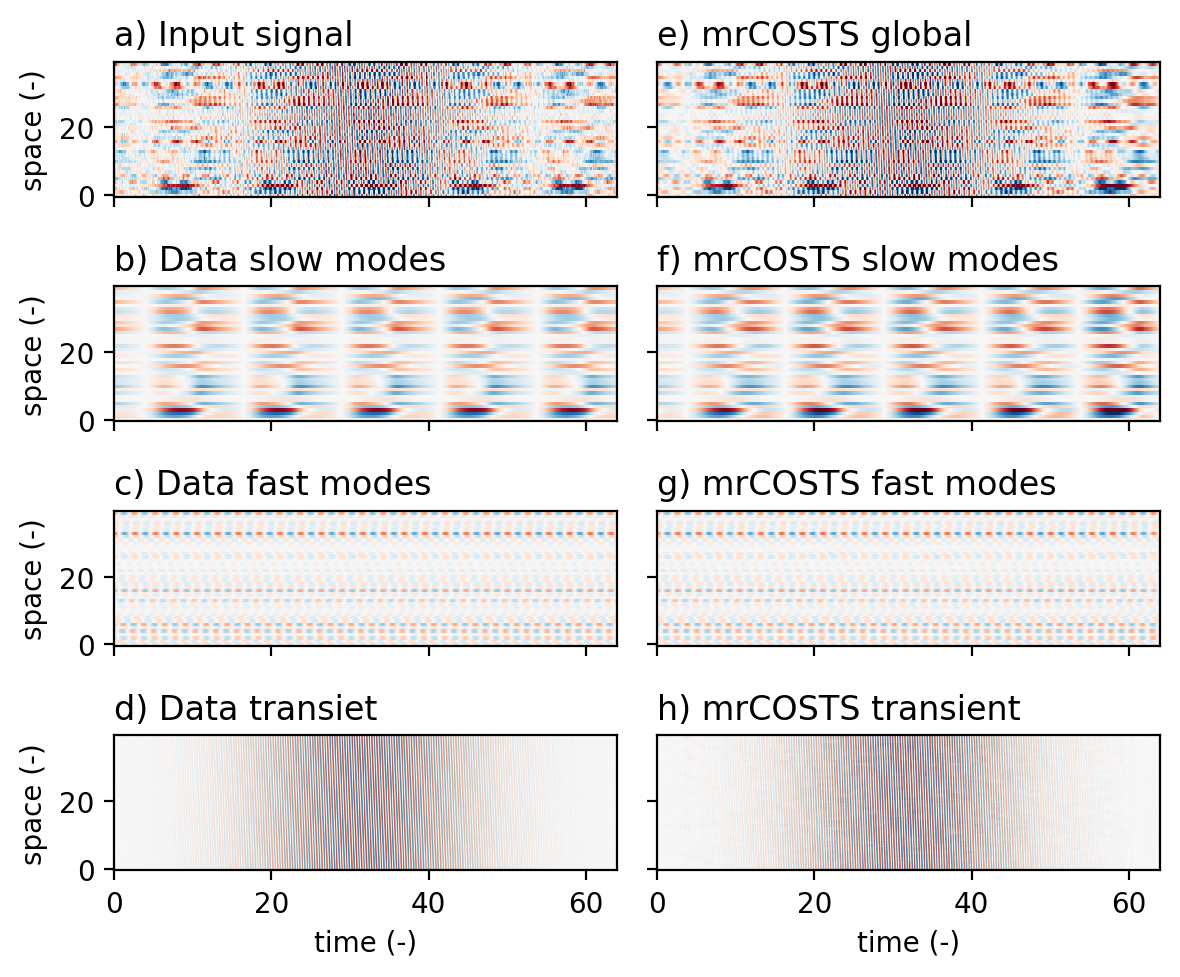

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(6, 5), sharex=True, sharey=True)

pcolor_kwargs = {
    "vmin": -3,
    "vmax": 3,
    "cmap": "RdBu_r",
}

# Original data
ax = axes[0, 0]
ax.pcolor(time, space_dim, data_noisy, **pcolor_kwargs)
ax.set_title("a) Input signal", loc="left")
ax.set_ylabel("space (-)")

ax = axes[1, 0]
ax.pcolor(time, space_dim, slow_modes.T, **pcolor_kwargs)
ax.set_title("b) Data slow modes", loc="left")
ax.set_ylabel("space (-)")

ax = axes[2, 0]
ax.pcolor(time, space_dim, fast_modes.T, **pcolor_kwargs)
ax.set_title("c) Data fast modes", loc="left")
ax.set_ylabel("space (-)")

ax = axes[3, 0]
ax.pcolor(time, space_dim, x_transient, **pcolor_kwargs)
ax.set_title("d) Data transiet", loc="left")
ax.set_xlabel("time (-)")
ax.set_ylabel("space (-)")

# Reconstructions
ax = axes[0, 1]
ax.pcolor(time, space_dim, xr_global, **pcolor_kwargs)
ax.set_title("e) mrCOSTS global", loc="left")

ax = axes[1, 1]
ax.pcolor(time, space_dim, xr_slow + xr_background, **pcolor_kwargs)
ax.set_title("f) mrCOSTS slow modes", loc="left")

ax = axes[2, 1]
ax.pcolor(time, space_dim, xr_fast, **pcolor_kwargs)
ax.set_title("g) mrCOSTS fast modes", loc="left")

ax = axes[3, 1]
ax.pcolor(time, space_dim, xr_transient, **pcolor_kwargs)
ax.set_title("h) mrCOSTS transient", loc="left")
ax.set_xlabel("time (-)")

fig.tight_layout()

## Errors

In [13]:
error_global = mrc.costs_array[0].relative_error(xr_global, data_transient)
error_fast = mrc.costs_array[0].relative_error(xr_fast, fast_modes.T)
error_slow = mrc.costs_array[0].relative_error(xr_slow + xr_background, slow_modes.T)
error_transient = mrc.costs_array[0].relative_error(xr_transient, x_transient)

print(f"Global error = {error_global:.2f}")
print(f"Slow modes error = {error_slow:.2f}")
print(f"Fast modes error = {error_fast:.2f}")
print(f"Transient modes error = {error_transient:.2f}")

Global error = 0.12
Slow modes error = 0.19
Fast modes error = 0.09
Transient modes error = 0.06


Visualizing the fit at a point.

Text(0.5, 1.0, 'Fit against data without noise')

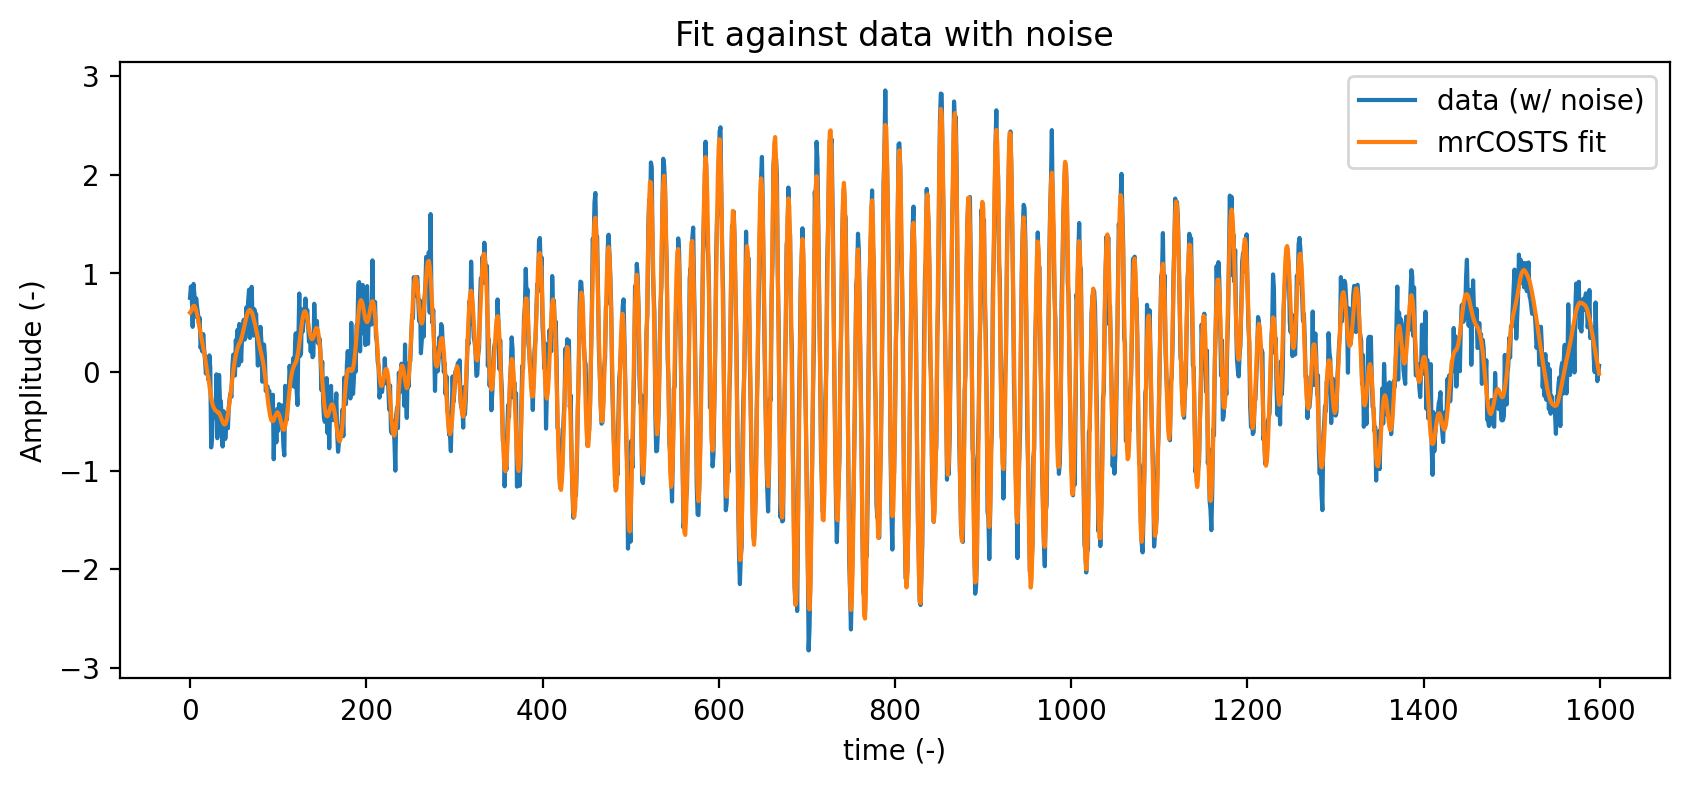

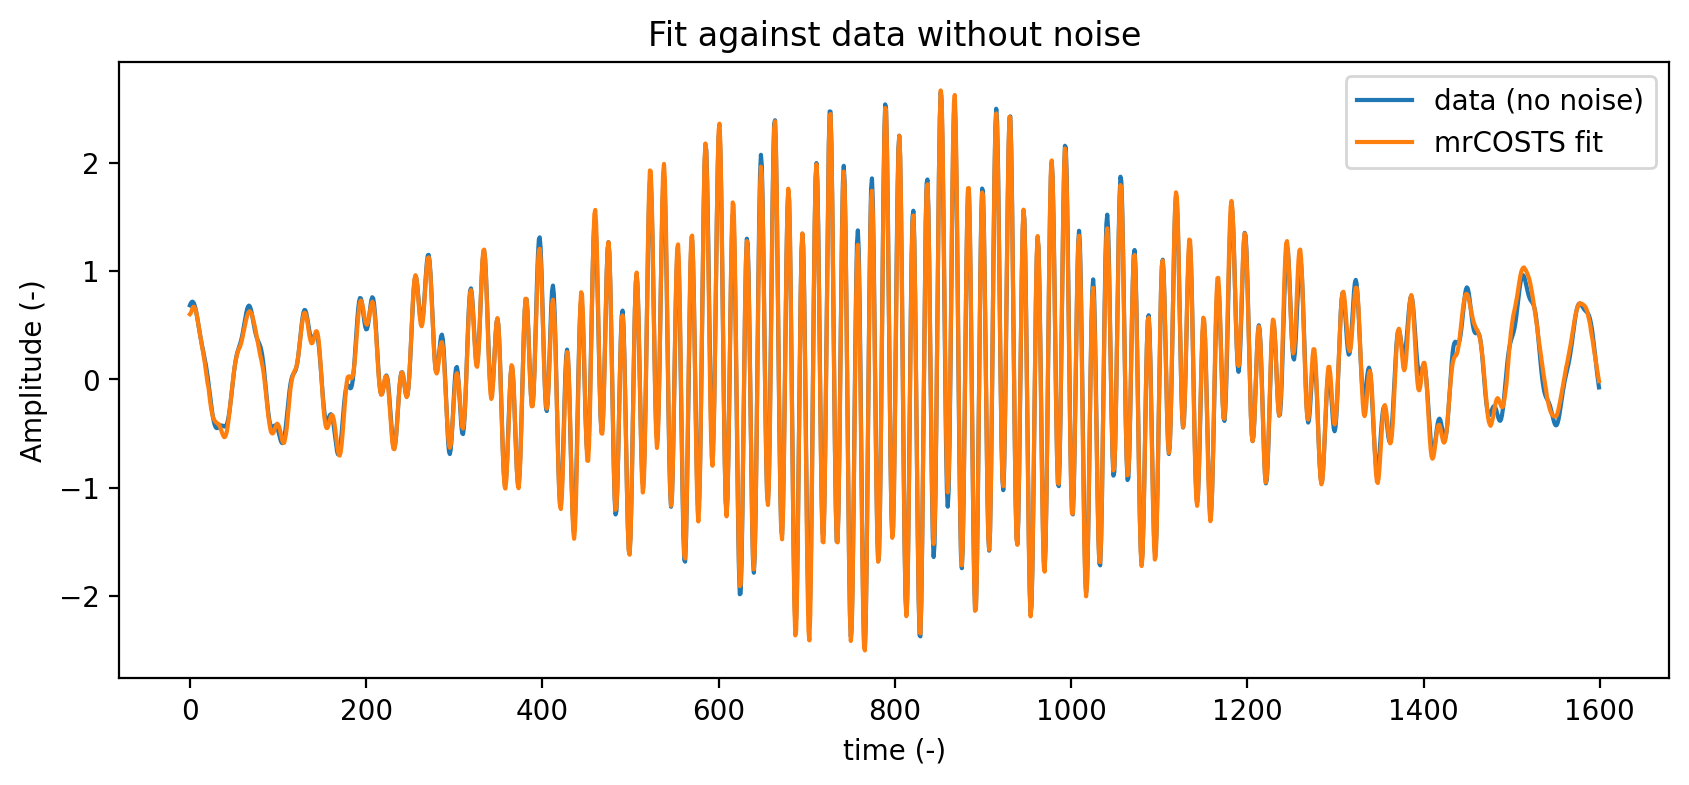

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(data_noisy[0, :], label="data (w/ noise)")
plt.plot(xr_global[0, :], label="mrCOSTS fit")
plt.legend()
plt.xlabel("time (-)")
plt.ylabel("Amplitude (-)")
plt.title("Fit against data with noise")

plt.figure(figsize=(10, 4))
plt.plot(data_transient[0, :], label="data (no noise)")
plt.plot(xr_global[0, :], label="mrCOSTS fit")
plt.legend()
plt.xlabel("time (-)")
plt.ylabel("Amplitude (-)")
plt.title("Fit against data without noise")

mrCOSTS fits largely drop white noise as white noise is not spatially coherent.

# Conclusion

We used mrCOSTS to extract out the three dominant spatiotemporal patterns in the toy data. These toy data were fairly ill-conditioned (a common problem in toy data sets) but even so mrCOSTS could robustly retrieve the constituent dynamics of the system.